# Artifact_Exploration
Looking at LED artifacts (are they electrical? photonic stimulation?) seen on Neuronexus recordings while shining an LED stimulus on an anesthetized, non-injected mouse.


Goal is to isolate potential artifacts so that we can find any *actual* spikes evoked in an injected mouse.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from open_ephys.analysis import Session
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal.windows import gaussian
import time
import ipympl
import os
from sklearn.decomposition import PCA
%matplotlib ipympl
# from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
os.listdir('Z:\\BrainPatch\\20240925')

Load the data

In [4]:
# go through each directory
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-29-59__20mA_MinOil_2ms'
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_16-33-23__spontaneous_touching_newprobe'
# directory = "Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_15-04-03__5mA_MinOil_2ms"
# directory = "Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_15-10-03__20mA_MinOil_2ms"
# directory = "Z:\\BrainPatch\\20240806\\Spontaneous_test__2024-08-06_13-58-38__Barrel_cable2"
# directory = 'Z:\\BrainPatch\\20240925\\Crimson__2024-09-25_13-22-26__20mA_2ms_0mm'
# directory = 'Z:\\BrainPatch\\20240925\\No_Mineral_Oil\\Crimson__2024-09-25_11-44-38__20mA_0mm_2ms'
directory = 'Z:\\BrainPatch\\20240925\\No_Mineral_Oil\\Crimson__2024-09-25_12-29-03__awake'

session = Session(directory)
print(session)


Open Ephys Recording Session Object
Directory: Z:\BrainPatch\20240925\No_Mineral_Oil\Crimson__2024-09-25_12-29-03__awake

<object>.recordnodes:
  Index 0: Record Node 101 (binary format)



Give an overview of the session -- recursively look through each of the sub-pieces

In [ ]:
if session.recordnodes:
    print(f'recording contains recordnodes')
    for i_rec in range(len(session.recordnodes)):
        print(f'{len(session.recordnodes[i_rec].recordings)} recording(s) in session "{session.recordnodes[i_rec].directory}"\n')
        recordings = session.recordnodes[i_rec].recordings
        
        for i_rec,recording in enumerate(recordings):
            recording.load_continuous()
            recording.load_spikes()
            recording.load_events()
            recording.load_messages()

            print(f'Recording {i_rec} has:')
            print(f'\t{len(recording.continuous)} continuous streams')
            print(f'\t{len(recording.spikes)} spike streams')
            print(f'\t{len(recording.events)} event streams')
        
        print('\n')

else:
    print(f'recording does not contain recordnodes')
    print(f'{len(session.recordings)} recording(s) in session "{session.directory}"\n\n')
    recordings = session.recordings

    for i_rec,recording in enumerate(recordings):
        recording.load_continuous()
        recording.load_spikes()
        recording.load_events()
        recording.load_messages()

        print(f'Recording {i_rec} has:')
        print(f'\t{len(recording.continuous)} continuous streams')
        print(f'\t{len(recording.spikes)} spike streams')
        print(f'\t{len(recording.events)} event streams')



# Plotting

Take a look at continuous streams without the events on top -- this is primarily for the "no stim" situation

take a look at the stimulation artifacts

Text(0.5, 0, 'Time (s)')

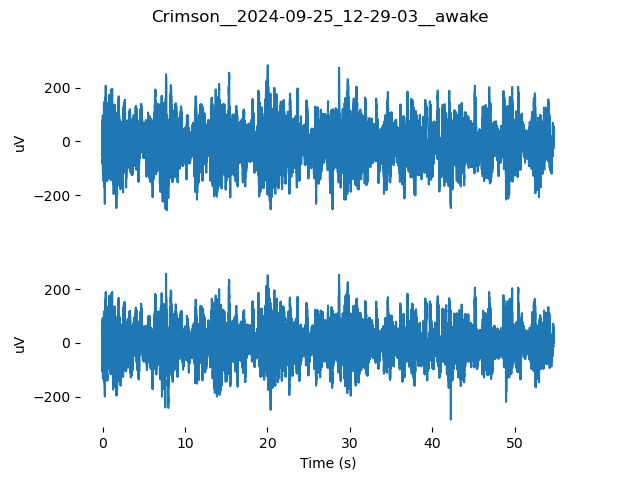

In [5]:
if session.recordnodes:
    recording = session.recordnodes[0].recordings[0]
    # recording = session.recordnodes[1].recordings[0]
else:
    # recording = session.recordings[0]
    recording = session.recordings[1]

max_cont = 2
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont < max_cont else max_cont

fig_event, ax_event = plt.subplots(nrows=n_cont, sharex=True, sharey=True)

# set up the events to plot patches
events = recording.events.sample_number.values - recording.continuous[0].sample_numbers[0] # to make sure we're starting at the same point
events = events/recording.info['events'][0]['sample_rate']
events = events.reshape([int(events.shape[0]/2),2])
# event_vertical = [recording.continuous[0].samples.max()* recording.continuous[0].metadata['bit_volts'][i_cont], recording.continuous[0].samples.min()* recording.continuous[0].metadata['bit_volts'][i_cont]] 

timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']
for i_cont in range(n_cont):
    # plot in volts
    values = recording.continuous[0].samples[:,i_cont]*recording.continuous[0].metadata['bit_volts'][i_cont]
    ax_event[i_cont].plot(timestamps, values)

    # plot the event times
    for i_event,event in enumerate(events):
        # print(f'{i_event}:{event}')
        ax_event[i_cont].axvspan(event[0], event[1], color='k', alpha=.1)

    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_event[i_cont].spines[spine].set_visible(False)

    # make only bottom ticks visible
    if i_cont < (n_cont-1):
        ax_event[i_cont].xaxis.set_visible(False)
    
    ax_event[i_cont].set_ylabel('uV')

fig_event.suptitle(os.path.split(directory)[-1])
ax_event[-1].set_xlabel('Time (s)')

In [ ]:
recording.continuous[0].samples.shape

In [ ]:
fig,ax = plt.subplots(nrows = 8, sharex=True)

for i, elec in enumerate([64,65,66,67,68,69,70,71]):
    ax[i].plot(recording.continuous[0].samples[:,elec])



Let's look at the spectrogram and the power spectrum for the signal

In [ ]:
# len_gauss = 1024
# std = 128
# hop=128
len_gauss = 30000
std = 300
hop = 300

window = gaussian(len_gauss, std, sym=True)
fs = recording.continuous[0].metadata['sample_rate']
sft = signal.ShortTimeFFT(window, hop=hop, fs=fs, scale_to='magnitude')

if session.recordnodes:
    recording = session.recordnodes[0].recordings[0]
else:
    recording = session.recordings[0]

# number of signals etc
max_cont = 6
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont <= max_cont else max_cont

# length of the recording -- cleans up the code
n_samples = recording.continuous[0].samples.shape[0] 

# start a sft with a subplot for each continuous signal plotted
fig_sft, ax_sft = plt.subplots(nrows=n_cont, sharex=True, sharey=True)

fig_sft.suptitle(rf"sft ({sft.m_num*sft.T:g}$\,s$ Gaussian window, " +
                 rf"$\sigma_t={std*sft.T}\,$s)")

for i_cont in range(n_cont):
    values = recording.continuous[0].samples[:,i_cont]*recording.continuous[0].metadata['bit_volts'][i_cont]
    Sx = sft.stft(values)
    
    # time range of the plot
    t_lo, t_hi = sft.extent(n_samples)[:2]

    # plot the spectrogram
    ax_sft[i_cont].imshow(abs(Sx[:]), origin='lower', aspect='auto',
                          extent=sft.extent(n_samples), cmap='viridis')
    
    # shade areas where slice stick outside of the signal
    for t0_, t1_ in [(t_lo, sft.lower_border_end[0] * sft.T), (sft.upper_border_begin(n_samples)[0] * sft.T, t_hi)]:
        ax_sft[i_cont].axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

    # and mark the borders with a vertical line:
    for t_ in [0, n_samples*sft.T]:
        ax_sft[i_cont].axvline(t_, color='y', linestyle='--', alpha=0.5)

    # make only bottom ticks visible
    if i_cont < (n_cont-1):
        ax_sft[i_cont].xaxis.set_visible(False)

    # clean everything out
    ax_sft[i_cont].set(xlim=(t_lo, t_hi))
    ax_sft[i_cont].set(ylim=(0,300))

    
    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_sft[i_cont].spines[spine].set_visible(False)

# set up the labels on the bottom axis
ax_sft[-1].set_xlabel(f'Time $t$ in seconds')


welch's power spectrum

In [ ]:
# number of signals etc
max_cont = 6
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont <= max_cont else max_cont

fig_pow, ax_pow = plt.subplots(nrows=max_cont, sharex=True, sharey=True)

for i_cont in range(n_cont):
    values = recording.continuous[0].samples[:,i_cont]*recording.continuous[0].metadata['bit_volts'][i_cont]
    val_f = signal.welch(values, fs=30000, nperseg=30000)
    
    # plot the spectrogram
    ax_pow[i_cont].loglog(val_f[0], np.abs(val_f[1]))
    
    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_pow[i_cont].spines[spine].set_visible(False)

# set up the labels on the bottom axis
# ax_pow[-1].set_xlabel(f'Time $t$ in seconds')



Find the mean and variance of the stimulus artifacts.

To do this, we'll take the difference between the maximum value and the mean value during the stimulation period

In [ ]:
# number of signals etc
max_cont = 6
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont <= max_cont else max_cont

# set up the events to plot patches
events = recording.events.sample_number.values - recording.continuous[0].sample_numbers[0] # to make sure we're starting at the same point
events = events/recording.info['events'][0]['sample_rate']
events = events.reshape([int(events.shape[0]/2),2])

for i_cont in range(n_cont):
    values = recording.continuous[0].samples[:,i_cont]*recording.continuous[0].metadata['bit_volts'][i_cont]

    for event in 


# for event in events:

# Clean the signal

CAR and filter

In [6]:
# we'll start by removing the common average

# pull out the recordings
if session.recordnodes:
    continuous = session.recordnodes[0].recordings[0].continuous[0].samples[:,:64]
else:
    continuous = session.recordings[0].continuous[0].samples[:,:64]

# get the mean and subtract it
mean_sig = np.mean(continuous, axis=1)
cont_CAR = continuous - np.tile(mean_sig, (continuous.shape[1], 1)).T

# And filter them
sos = signal.butter(16, [300, 6000], btype='bandpass', fs=30000, output='sos')
CAR_filt = signal.sosfiltfilt(sos, cont_CAR, axis=0)
cont_filt = signal.sosfiltfilt(sos, continuous, axis=0)

# FIR filter
# filt = signal.firwin2(73, [0, 250, 350, 6000, 10000, 15000], [0, 0, 1, 1, 0, 0], fs=30000)
# CAR_filt = np.array([signal.convolve(cont, filt) for cont in cont_CAR.T]).T
# cont_filt = np.array([signal.convolve(cont, filt) for cont in continuous.T]).T

c:\Users\Kevin\miniconda3\envs\brainpatch\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


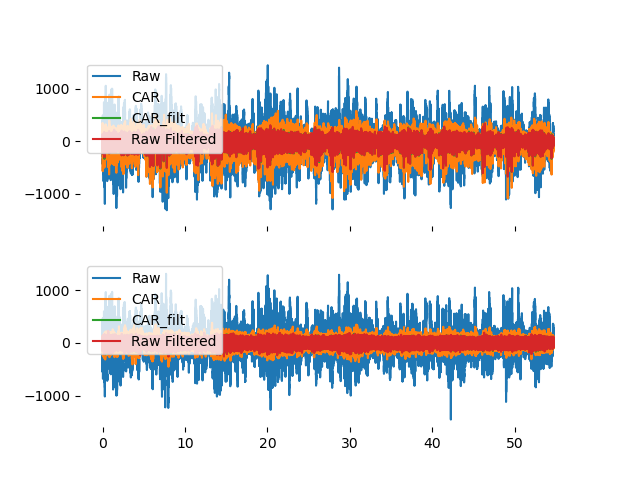

In [7]:
max_cont = 2
n_cont = recording.continuous[0].samples.shape[1] 
n_cont = n_cont if n_cont <= max_cont else max_cont

fig_clean, ax_clean = plt.subplots(nrows=max_cont, sharex=True, sharey=True)

# events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
# events = events/recording.continuous[0].metadata['sample_rate']
# events = events.reshape([int(events.shape[0]/2),2])

timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']
for i_cont in range(n_cont):
    ax_clean[i_cont].plot(timestamps, continuous[:,i_cont])
    ax_clean[i_cont].plot(timestamps, cont_CAR[:,i_cont])
    ax_clean[i_cont].plot(timestamps, CAR_filt[:len(timestamps),i_cont])
    ax_clean[i_cont].plot(timestamps, cont_filt[:len(timestamps),i_cont])

    # add a legend
    ax_clean[i_cont].legend(('Raw','CAR','CAR_filt', 'Raw Filtered'))
    
    # plot the event times
    # for i_event,event in enumerate(events):
    #     # print(f'{i_event}:{event}')
    #     ax_clean[i_cont].axvspan(event[0], event[1], color='k', alpha=.1)
    
    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_clean[i_cont].spines[spine].set_visible(False)

For the recordings with the precision current source I didn't record the stimulation times as "events" so instead I'm looking at the continuous signal from the auxiliary port and using a threshold to find the stimulation times instead

Text(0.5, 0, 'Time (s)')

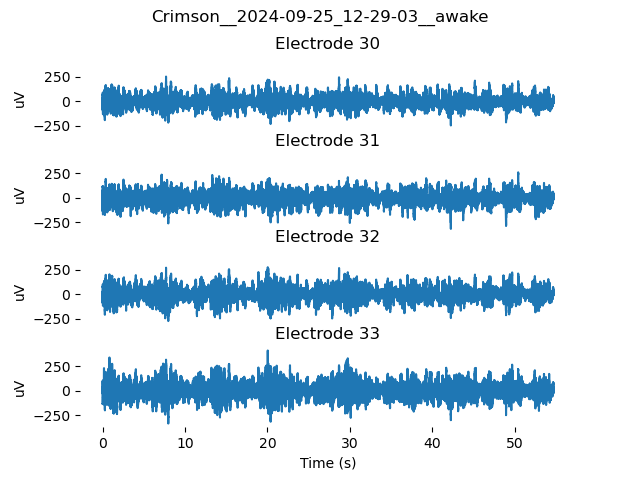

In [8]:
if session.recordnodes:
    recording = session.recordnodes[0].recordings[0]
else:
    recording = session.recordings[0]

electrodes = [30, 31, 32, 33]
n_cont = len(electrodes)
# max_cont = 6
# n_cont = recording.continuous[0].samples.shape[1] 
# n_cont = n_cont if n_cont < max_cont else max_cont

fig_event, ax_event = plt.subplots(nrows=n_cont, sharex=True, sharey=True)

# set up the events to plot patches
events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
events = events/recording.continuous[0].metadata['sample_rate']
events = events.reshape([int(events.shape[0]/2),2])

timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']
# for i_cont in range(n_cont):
for i_cont,cont in enumerate(electrodes):
    # plot in volts
    values = recording.continuous[0].samples[:,cont]*recording.continuous[0].metadata['bit_volts'][cont]
    ax_event[i_cont].plot(timestamps, values)

    # plot the event times
    for i_event,event in enumerate(events):
        # print(f'{i_event}:{event}')
        ax_event[i_cont].axvspan(event[0], event[1], color='k', alpha=.1)

    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_event[i_cont].spines[spine].set_visible(False)

    # make only bottom ticks visible
    if i_cont < (n_cont-1):
        ax_event[i_cont].xaxis.set_visible(False)
    
    ax_event[i_cont].set_ylabel('uV')
    ax_event[i_cont].set_title(f'Electrode {cont}')

fig_event.suptitle(os.path.split(directory)[-1])
ax_event[-1].set_xlabel('Time (s)')

Try it with PCA

In [9]:
pca = PCA()
pca.fit(continuous[:,:64])

pca

PCA()

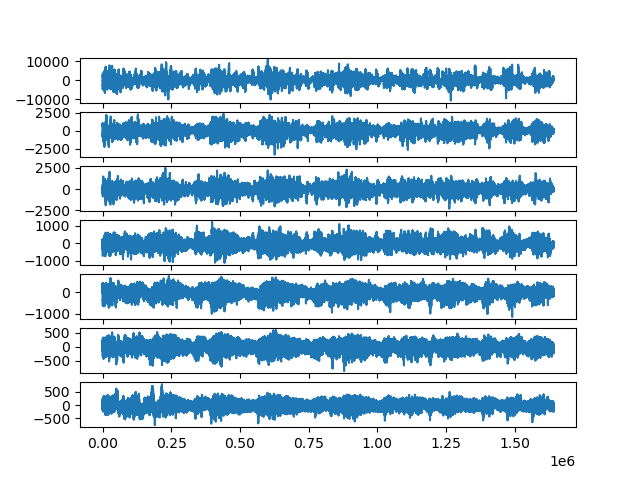

In [26]:
fig_pca, ax_pca = plt.subplots(nrows=7, sharex=True)

pcs = np.matmul(continuous[:,:64],pca.components_.T)

for i_ax, ax in enumerate(ax_pca):
    ax.plot(pcs[:,i_ax])

ax_

In [14]:
pca.components_.shape

(64, 64)